# Skill Demand

Identify which skills appear most often in job postings for the most common data roles.

## Import Libraries and Data

In [28]:
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('E:/Projects/Python_Data_Project/job_postings_flat_cleaned.csv')

## Prepare Skills for Analysis

Parse `job_skills`, keep only postings with non-empty skill lists, and explode skills into one row per skill mention.

In [29]:
df["job_skills"] = df["job_skills"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
mask_skills = df["job_skills"].apply(lambda x: isinstance(x, list) and len(x) > 0)
df_skills = df.loc[mask_skills].explode("job_skills").copy()

## Skill Counts by Role

Count how often each skill appears within each role to create the base table used in the rest of the analysis.

In [30]:
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

df_skills_count = df_skills_count.reset_index(name='skill_count')

df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1893,sql,Data Engineer,222410
1547,python,Data Engineer,214026
1548,python,Data Scientist,195128
1892,sql,Data Analyst,173406
1894,sql,Data Scientist,136394
...,...,...,...
2293,workfront,Senior Data Engineer,1
1021,linode,Senior Data Analyst,1
1058,lua,Senior Data Analyst,1
2255,wimi,Data Scientist,1


## Identify the Top Roles

Select the top 3 roles by posting volume to keep the comparison focused on the most common roles.

In [31]:
job_titles = df["job_title_short"].value_counts().head(3).index.tolist()

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Convert Counts to Percentages

- Convert raw skill counts into within-role percentages to compare skills fairly across roles of different sizes.

- Skill_percent is calculated as skill_count / jobs_total_with_skills * 100, where jobs_total_with_skills counts only postings where job_skills is a non-empty list for a given role.

In [32]:
df_job_title_count = (
    df.loc[mask_skills, "job_title_short"]
      .value_counts()
      .reset_index(name="jobs_total_with_skills")
      .rename(columns={"index": "job_title_short"})
)

df_job_title_count

,job_title_short,jobs_total_with_skills
0,Data Engineer,333871
1,Data Analyst,300407
2,Data Scientist,254625
3,Senior Data Engineer,82101
4,Software Engineer,75163
5,Business Analyst,71618
6,Senior Data Scientist,57206
7,Senior Data Analyst,47485
8,Machine Learning Engineer,33892
9,Cloud Engineer,20476


In [33]:
df_skills_perc = df_skills_count.merge(df_job_title_count, on="job_title_short", how="left")

df_skills_perc["skill_percent"] = (
    df_skills_perc["skill_count"] / df_skills_perc["jobs_total_with_skills"] * 100
)

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total_with_skills,skill_percent
0,sql,Data Engineer,222410,333871,66.615549
1,python,Data Engineer,214026,333871,64.104400
2,python,Data Scientist,195128,254625,76.633481
3,sql,Data Analyst,173406,300407,57.723688
4,sql,Data Scientist,136394,254625,53.566618
...,...,...,...,...,...
2339,workfront,Senior Data Engineer,1,82101,0.001218
2340,linode,Senior Data Analyst,1,47485,0.002106
2341,lua,Senior Data Analyst,1,47485,0.002106
2342,wimi,Data Scientist,1,254625,0.000393


## Plot Percentage Count

Plot skill likelihood for each top role, defined as the share of postings (among those with captured skills) that mention a given skill.

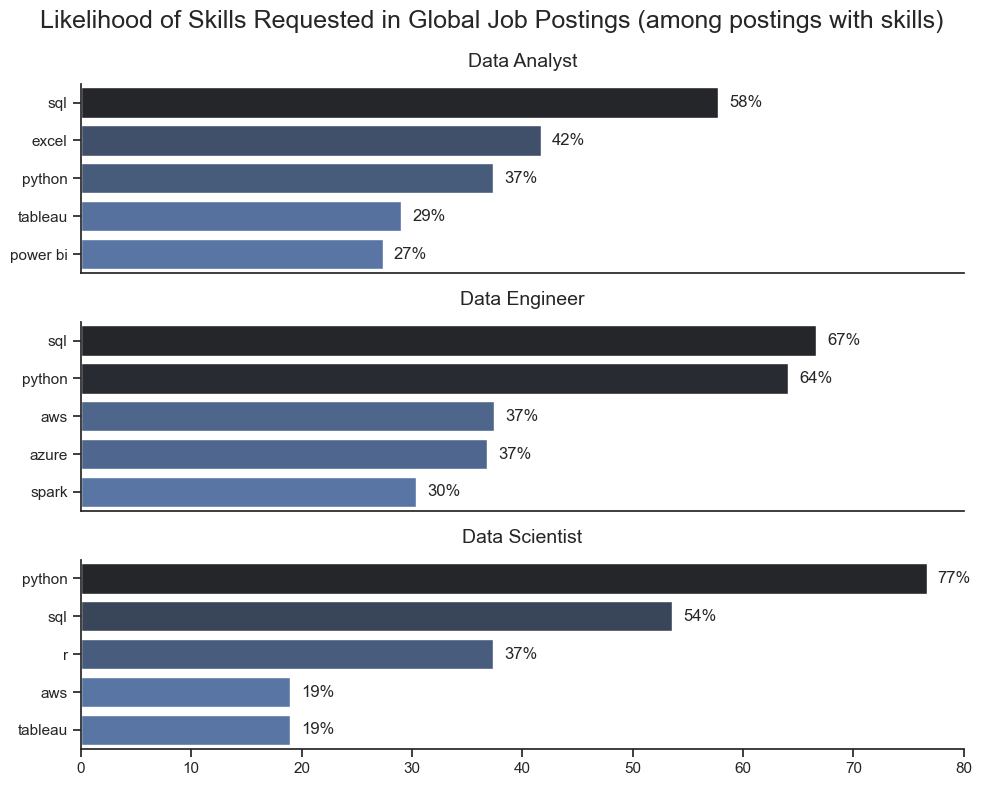

In [34]:
sns.set_theme(style="ticks")

fig, axes = plt.subplots(len(job_titles), 1, figsize=(10, 8), squeeze=False)

for i, job_title in enumerate(job_titles):
    df_plot = (
        df_skills_perc[df_skills_perc["job_title_short"] == job_title]
        .sort_values("skill_percent", ascending=False)
        .head(5)
        .copy()
    )

    sns.barplot(
        data=df_plot,
        x="skill_percent",
        y="job_skills",
        ax=axes[i][0],
        hue="skill_count",
        palette="dark:b_r",
        legend=False
    )

    axes[i][0].set_title(f"{job_title}", fontsize=14, pad=12)
    axes[i][0].set_ylabel("")
    axes[i][0].set_xlabel("")
    axes[i][0].set_xlim(0, 80)

    if i != len(job_titles) - 1:
        axes[i][0].set_xticks([])

    for n, v in enumerate(df_plot["skill_percent"]):
        axes[i][0].text(v + 1, n, f"{v:.0f}%", va="center")

    sns.despine(ax=axes[i][0])

fig.suptitle("Likelihood of Skills Requested in Global Job Postings (among postings with skills)", fontsize=18)
fig.tight_layout()
plt.show()